# Imports

In [19]:
from dqn.dqn import QNetwork, ReplayMemory
from policies.eps_greedy import EpsilonGreedyPolicy
from train_eval.train import train

import random
import numpy as np
import torch
from torch import optim
import gym
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from copy import deepcopy

# Load the environment

In [20]:
env = gym.envs.make("CartPole-v1")

# Function to run episodes and call training function (memory off, baseline)

In [21]:
def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    state_values = []
    init_state = env.reset()
    for i in tqdm(range(1, num_episodes+1)):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Increase step counts
            steps += 1
            global_steps += 1
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Perform training on the buffer
            if global_steps % batch_size == 0:
                loss = train(Q, memory, optimizer, batch_size, discount_factor)
            state = s_next
            
            if done:
                episode_durations.append(steps)
                break
        if i == 1 or i % 100 == 0:
            with torch.no_grad():
                Q.eval()
                Q_vals = Q(torch.Tensor([init_state]))
                maxx, _ = torch.max(Q_vals, dim=1)
                state_values.append(maxx)
    return episode_durations, state_values

# Train network (Replay memory off, baseline)

In [22]:
seed = 42  # This is not randomly chosen
num_hidden = 128
eps = 0.05

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden)
policy = EpsilonGreedyPolicy(Q_net, eps)

num_episodes = 10000
batch_size = 64
discount_factor = 0.9
learn_rate = 1e-3

# We switch off Replay Memory mechanism by setting the memory size to batch size
# This is our baseline 
memory = ReplayMemory(batch_size)

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
episode_durations, state_values = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer)

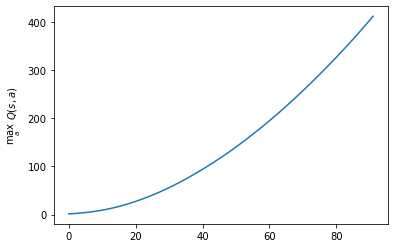

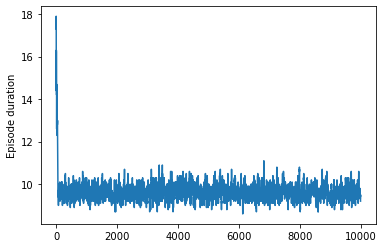

In [23]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(np.array(state_values), 10))
plt.ylabel('$\max_a\ Q(s,a)$')
plt.show()

plt.plot(smooth(np.array(episode_durations), 10))
plt.ylabel('Episode duration')
plt.show()

# Function to run episodes and call training function (memory on)

In [24]:
def run_episodes_memory(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer):
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    state_values = []
    init_state = env.reset()
    print(memory.capacity)
    for i in tqdm(range(1, num_episodes+1)):
        state = env.reset()

        steps = 0
        while True:
            # Set epsilon according to number of steps
            policy.set_epsilon(global_steps)
            # Increase step counts
            steps += 1
            global_steps += 1
            # Sample an action, next state, reward and done
            a = policy.sample_action(state)
            s_next, r, done, _ = env.step(a)
            # Add the transition to the memory buffer
            memory.push((state, a, r, s_next, done))
            # Perform training on the buffer
            loss = train(Q, memory, optimizer, batch_size, discount_factor)
            state = s_next
            
            if done:
                episode_durations.append(steps)
                break
        if i == 1 or i % 100 == 0:
            with torch.no_grad():
                Q.eval()
                Q_vals = Q(torch.Tensor([init_state]))
                maxx, _ = torch.max(Q_vals, dim=1)
                state_values.append(maxx)
    return episode_durations, state_values

# Train network (now replay memory on)

In [25]:
seed = 42  # This is not randomly chosen
num_hidden = 128
eps = 0.05

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden=num_hidden)
policy = EpsilonGreedyPolicy(Q_net, eps)

num_episodes = 10000
batch_size = 64
discount_factor = 0.9
learn_rate = 1e-3

# We first test Replay Memory by setting the memory size to 10.000 
memory = ReplayMemory(10000)

optimizer = optim.Adam(Q_net.parameters(), learn_rate)
episode_durations, state_values = run_episodes_memory(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, optimizer)

10000


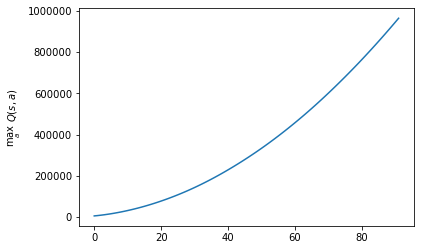

101 10000


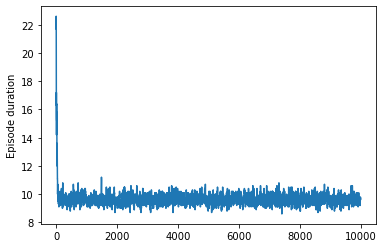

In [26]:
plt.plot(smooth(np.array(state_values), 10))
plt.ylabel('$\max_a\ Q(s,a)$')
plt.show()
print(len(state_values), len(episode_durations))
plt.plot(smooth(np.array(episode_durations), 10))
plt.ylabel('Episode duration')
plt.show()

# Proof of concept done, time for testing

In [27]:
# Fixed hyperparams among experiments
num_hidden = 128
eps = 0.05
num_episodes = 10000
batch_size = 64
discount_factor = 0.9
learn_rate = 1e-3

# Number of experiments to average results over
num_experiments = 10

# Memory sizes to be tested
test_memory_sizes = [64, 100, 500, 1000, 10000]

# Make buffers for the cumulative results
cum_state_values = {i : [] for i in test_memory_sizes}
cum_episode_durations = {i : [] for i in test_memory_sizes}

for memory_size in test_memory_sizes:
    print("Current memory size:", memory_size)
    for i in tqdm(range(num_experiments)):
        
        # Set the seed such that each update frequency is tested on the same seeds
        random.seed(i)
        torch.manual_seed(i)
        env.seed(i)
        
        # Create network, policy and replaymemory (which is not used; renewed every batch)
        Q_net = QNetwork(num_hidden=num_hidden)
        policy = EpsilonGreedyPolicy(Q_net, eps)
        
        # Use current test memory size
        memory = ReplayMemory(memory_size)

        optimizer = optim.Adam(Q_net.parameters(), learn_rate)
        
        if memory_size == batch_size:
            # Replay memory off
            print("Replay memory off")
            episode_durations, state_values = run_episodes(
                    train,
                    Q_net, policy,
                    memory,
                    env,
                    num_episodes,
                    batch_size,
                    discount_factor,
                    optimizer,
            )
        else:
            episode_durations, state_values = run_episodes_memory(
                    train,
                    Q_net, policy,
                    memory,
                    env,
                    num_episodes,
                    batch_size,
                    discount_factor,
                    optimizer,
            )
        
        cum_state_values[memory_size].append(np.array(state_values))
        cum_episode_durations[memory_size].append(np.array(episode_durations))

Current memory size: 64


Replay memory off


Replay memory off


Replay memory off


Replay memory off


Replay memory off


Replay memory off


Replay memory off


Replay memory off


Replay memory off


Replay memory off



Current memory size: 100


100


100


100


100


100


100


100


100


100


100



Current memory size: 500


500


500


500


500


500


500


500


500


500


500



Current memory size: 1000


1000


1000


1000


1000


1000


1000


1000


1000


1000


1000



Current memory size: 10000


10000


10000


10000


10000


10000


10000


10000


10000


10000


10000


In [1]:
# Average over the cumulative results
for size in test_memory_sizes:
    cum_state_values[size] = np.array(cum_state_values[size])
    cum_episode_durations[size]  = np.array(cum_episode_durations[size])
    
# print(cum_state_values[64])

# Plot initial state value over time (Memory = off = Baseline for everyone)
size = test_memory_sizes[0]
stds = np.std(cum_state_values[size], axis=0)
mean_values = np.mean(cum_state_values[size], axis=0)
plt.fill_between(np.linspace(1, (num_episodes//100)+1, num=(num_episodes//100)+1), mean_values-stds, mean_values+stds, alpha=0.3)
plt.plot(mean_values)
plt.ylabel('$\max_a\ Q(s_0,a)$')
plt.xlabel('Episode')
# figure_memory_sizes = ["Off"]
# plt.legend([f'Memory = {size}' for size in figure_memory_sizes], loc=2)
ticks = [0, 20, 40, 60, 80, 100]
plt.xticks(ticks, [t*100 for t in ticks])
plt.savefig("baseline_1.png")
plt.show()


# Plot episode duration over time
size = test_memory_sizes[0]
smooth_stds = smooth(np.std(cum_episode_durations[size], axis=0), 100)
smooth_mean_values = smooth(np.mean(cum_episode_durations[size], axis=0), 100)
plt.fill_between(np.linspace(1, len(smooth_stds), num=len(smooth_stds)), smooth_mean_values-smooth_stds, smooth_mean_values+smooth_stds, alpha=0.3)
plt.plot(smooth_mean_values)
plt.ylabel('Episode duration')
plt.xlabel('Episode')
# plt.legend([f'Memory = {size}' for size in figure_memory_sizes], loc=2)
plt.savefig("baseline_2.png")
plt.show()

  
# Plot initial state value over time
for size in test_memory_sizes[1:]:
    stds = np.std(cum_state_values[size], axis=0)
    mean_values = np.mean(cum_state_values[size], axis=0)
    plt.fill_between(np.linspace(1, (num_episodes//100)+1, num=(num_episodes//100)+1), mean_values-stds, mean_values+stds, alpha=0.3)
    plt.plot(mean_values)
plt.ylabel('$\max_a\ Q(s_0,a)$')
plt.xlabel('Episode')
figure_memory_sizes = [100, 500, 1000, 10000]
plt.legend([f'Memory = {size}' for size in figure_memory_sizes], loc=2)
ticks = [0, 20, 40, 60, 80, 100]
plt.xticks(ticks, [t*100 for t in ticks])
plt.savefig("experience_replay_1.png")
plt.show()


# Plot episode duration over time
for size in test_memory_sizes[1:]:
    smooth_stds = smooth(np.std(cum_episode_durations[size], axis=0), 100)
    smooth_mean_values = smooth(np.mean(cum_episode_durations[size], axis=0), 100)
    plt.fill_between(np.linspace(1, len(smooth_stds), num=len(smooth_stds)), smooth_mean_values-smooth_stds, smooth_mean_values+smooth_stds, alpha=0.3)
    plt.plot(smooth_mean_values)
plt.ylabel('Episode duration')
plt.xlabel('Episode')
plt.legend([f'Memory = {size}' for size in figure_memory_sizes], loc=2)
plt.savefig("experience_replay_2.png")
plt.show()


NameError: name 'test_memory_sizes' is not defined